In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as bar
import seaborn as sns
from ast import literal_eval

#General settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

#Load Data
df = pd.read_csv("../data/clean_streaming_metadata.csv")
print("Shape:", df.shape)
df.info()

Shape: (19911, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19911 entries, 0 to 19910
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         19911 non-null  object 
 1   type          19911 non-null  object 
 2   country       19911 non-null  object 
 3   release_year  19911 non-null  int64  
 4   genres        19911 non-null  object 
 5   imdb_rating   9659 non-null   float64
 6   imdb_votes    0 non-null      float64
 7   director      19911 non-null  object 
 8   cast          19911 non-null  object 
 9   date_added    19911 non-null  object 
 10  duration      19911 non-null  object 
 11  platform      19911 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.8+ MB


In [14]:
#View and check for missing values
df.head()
df.isna().sum().sort_values(ascending=False)

imdb_votes      19911
imdb_rating     10252
title               0
type                0
release_year        0
country             0
genres              0
director            0
cast                0
date_added          0
duration            0
platform            0
dtype: int64

In [15]:
#Base descriptive statistics for the numeric fields
print(df["release_year"].describe())
print(df["imdb_rating"].describe())

#Type (Movie vs TV)
type_dist = df["type"].value_counts(normalize=True) * 100
print(f"\n{type_dist}")

count    19911.000000
mean      2010.554116
std         15.949918
min       1920.000000
25%       2010.000000
50%       2016.000000
75%       2019.000000
max       2021.000000
Name: release_year, dtype: float64
count    9659.0
mean       16.0
std         0.0
min        16.0
25%        16.0
50%        16.0
75%        16.0
max        16.0
Name: imdb_rating, dtype: float64

type
Movie      75.254884
TV Show    24.745116
Name: proportion, dtype: float64


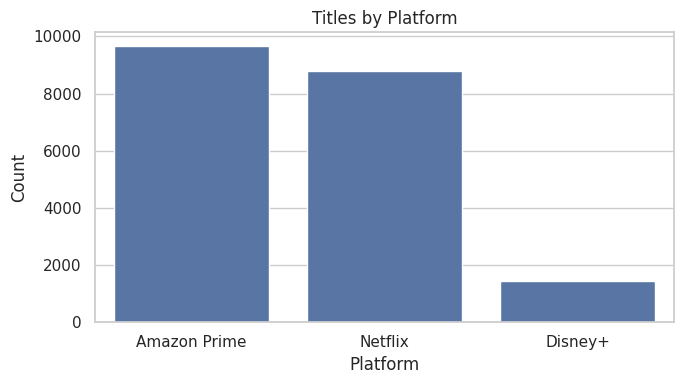

In [16]:
#Bar chart for total titles for each platform
bar.figure(figsize=(7,4))
sns.countplot(data=df, x="platform", order=df["platform"].value_counts().index)
bar.title("Titles by Platform")
bar.xlabel("Platform")
bar.ylabel("Count")
bar.tight_layout()
bar.show()

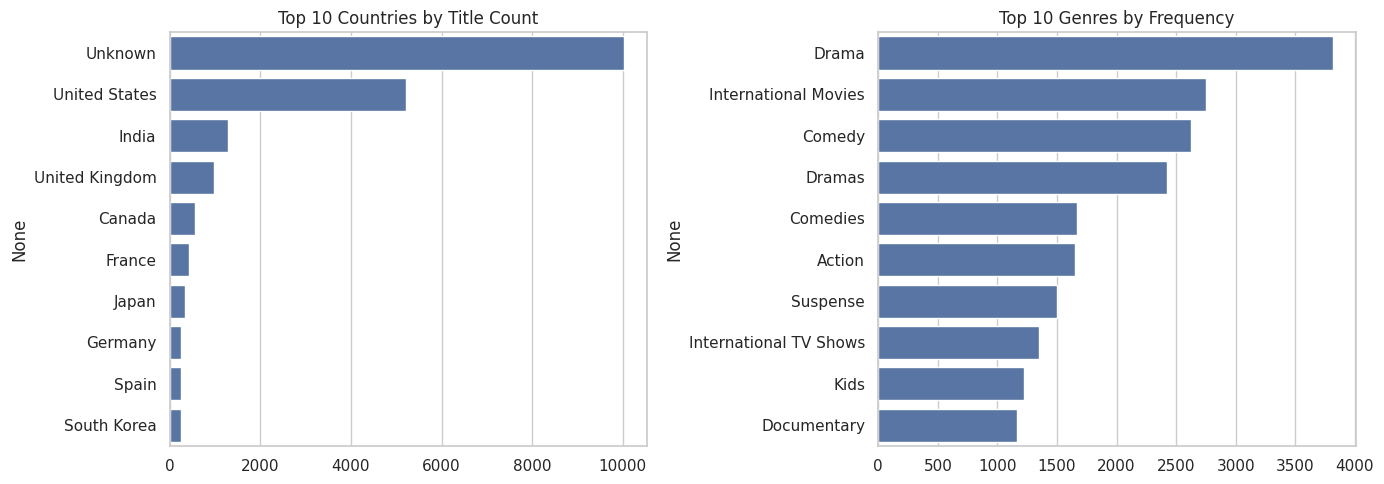

In [22]:
#Bar chart for Country and Genre frequency 
def Freq(column):
    values = df[column].dropna().apply(literal_eval)
    flat = [x for sublist in values for x in sublist if isinstance(x, str)]
    return pd.Series(flat).value_counts().head(10)

top_countries = Freq("country")
top_genres = Freq("genres")

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.barplot(x=top_countries.values, y=top_countries.index, ax=axes[0])
axes[0].set_title("Top 10 Countries by Title Count")

sns.barplot(x=top_genres.values, y=top_genres.index, ax=axes[1])
axes[1].set_title("Top 10 Genres by Frequency")

plt.tight_layout()
plt.show()


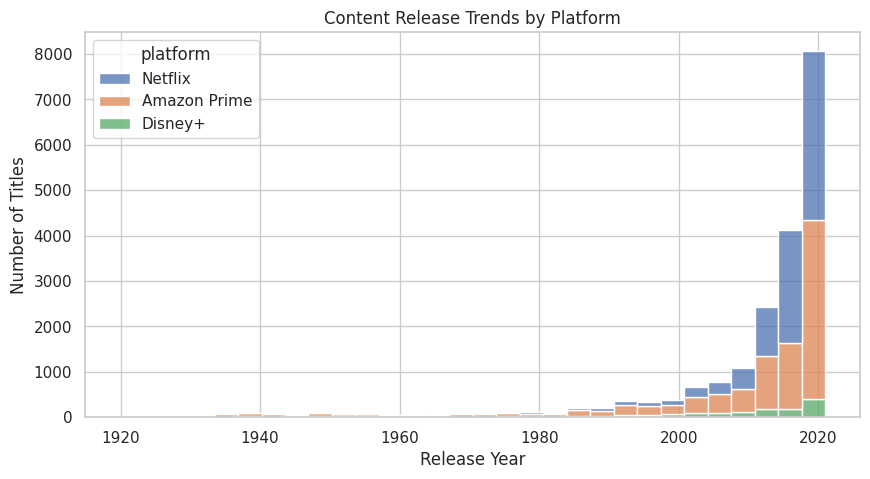

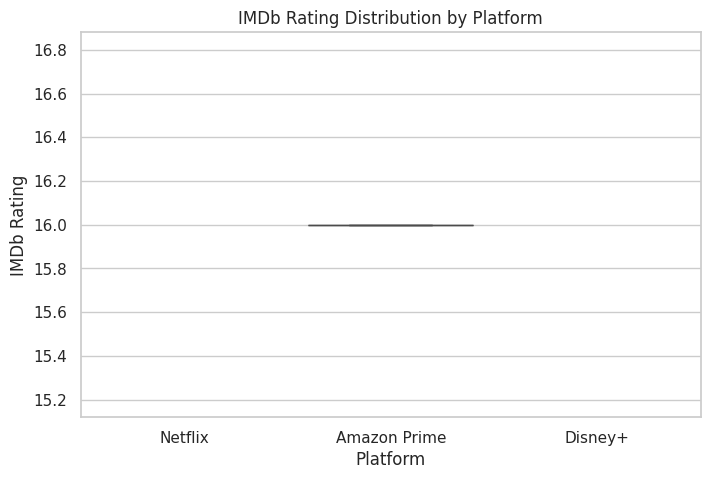

In [25]:
#Chart for content release over years

plt.figure(figsize=(10,5))
sns.histplot(df, x="release_year", hue="platform", multiple="stack", bins=30)
plt.title("Content Release Trends by Platform")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="platform", y="imdb_rating")
plt.title("IMDb Rating Distribution by Platform")
plt.xlabel("Platform")
plt.ylabel("IMDb Rating")
plt.show()


In [28]:
import os, pathlib
FIG_DIR = pathlib.Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("CWD:", os.getcwd(), " | Saving to:", FIG_DIR.resolve())

def savefig(fig, name):
    path = FIG_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", path)

# Platform distribution (example)
fig, ax = plt.subplots(figsize=(7,4))
sns.countplot(data=df, x="platform",
              order=df["platform"].value_counts().index, ax=ax)
ax.set_title("Titles by Platform")
ax.set_xlabel("Platform"); ax.set_ylabel("Count")
fig.tight_layout()
savefig(fig, "platform_distribution")


CWD: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/notebooks  | Saving to: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures
Saved: ../figures/platform_distribution.png


In [30]:
# 1) What columns mention "imdb"?
[c for c in df.columns if "imdb" in c.lower()]

# 2) Basic diagnostics
print("dtype:", df["imdb_rating"].dtype)
print("non-null count:", df["imdb_rating"].notna().sum())
print(df["imdb_rating"].dropna().head(10))

# 3) If dtype is 'object' or values look like strings, coerce to numeric
df["imdb_rating"] = pd.to_numeric(df["imdb_rating"], errors="coerce")

# 4) After coercion
print("dtype (post):", df["imdb_rating"].dtype)
print("non-null (post):", df["imdb_rating"].notna().sum())
df["imdb_rating"].describe()


dtype: float64
non-null count: 9659
8802    16.0
8803    16.0
8804    16.0
8805    16.0
8806    16.0
8807    16.0
8808    16.0
8809    16.0
8810    16.0
8811    16.0
Name: imdb_rating, dtype: float64
dtype (post): float64
non-null (post): 9659


count    9659.0
mean       16.0
std         0.0
min        16.0
25%        16.0
50%        16.0
75%        16.0
max        16.0
Name: imdb_rating, dtype: float64